# Import packages and data

In [1]:
#!pip install geopandas

In [2]:
#!pip install descartes

In [3]:
#!pip install plotly

In [4]:
# !pip install seaborn --upgrade

In [5]:
# !pip install dython

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import descartes
from shapely.geometry import Point, Polygon
import plotly.express as px
import datetime
from datetime import datetime
import seaborn as sns
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

from dython.nominal import associations
from dython.nominal import identify_nominal_columns

In [10]:
submission_format = pd.read_csv('SubmissionFormat.csv')
test_set_values = pd.read_csv('Test_set_values.csv')
tanzania_shp = gpd.read_file('stanford-yq759kh8097-geojson.json')

## Diagram of a pump 

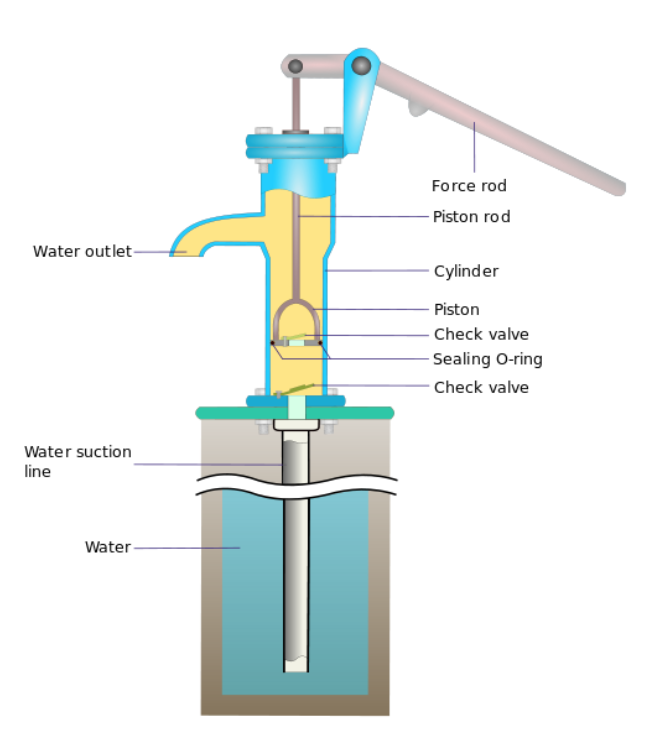

# Exploring training set

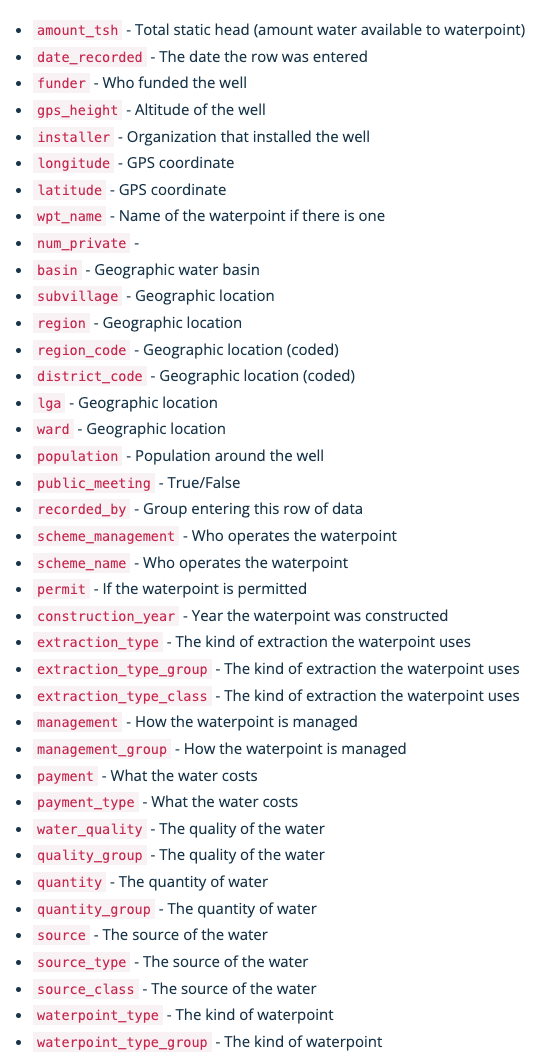

In [11]:
test_set_values.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [12]:
#age of pump, assuming age recorded is the day the pump was installed
def age(str_first_day):
    age = datetime.today() - datetime.strptime(str_first_day, '%Y-%m-%d') 
    return age.days

#get day, month and year of date_recorded
def get_day(str_date):
    datee = datetime.strptime(str_date, '%Y-%m-%d')
    day = datee.day
    return day

def get_month(str_date):
    datee = datetime.strptime(str_date, '%Y-%m-%d')
    month = datee.month
    return month

def get_year(str_date):
    datee = datetime.strptime(str_date, '%Y-%m-%d')
    year = datee.year
    return year

In [13]:
test_set_values['recorded_day'] = test_set_values['date_recorded'].apply(get_day)
test_set_values['recorded_month'] = test_set_values['date_recorded'].apply(get_month)
test_set_values['recorded_year'] = test_set_values['date_recorded'].apply(get_year)
test_set_values.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,recorded_day,recorded_month,recorded_year
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,4,2,2013
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,4,2,2013
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,1,2,2013
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,dry,dry,shallow well,shallow well,groundwater,other,other,22,1,2013
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,27,3,2013


In [14]:
len(test_set_values[test_set_values['construction_year'] == 0])

5260

In [15]:
len(test_set_values[test_set_values['construction_year'] != 0])

9590

## 1 third of the dataset doesn't have a year for when the well was built 

## Population around pump 

In [16]:
len(test_set_values[test_set_values['population'] == 0])

5453

In [17]:
len(test_set_values[test_set_values['population'] != 0])

9397

In [18]:
5453/(5453+9397)

0.3672053872053872

## 1 third of the pumps in the dataset have a population around well = 0 

In [19]:
print('Max Population: '+str(max(test_set_values.population))+'\nMin Population: '+str(min(test_set_values.population))+'\nAverage Population: '+str(test_set_values.population.mean()))

Max Population: 11469
Min Population: 0
Average Population: 184.11420875420876


## altitude of well

In [20]:
print('Max Altitude of Well: '+str(max(test_set_values.gps_height))+'\nMin Altitude of Well: '+str(min(test_set_values.gps_height))+'\nAverage Altitude of Well: '+str(test_set_values.gps_height.mean()))

Max Altitude of Well: 2777
Min Altitude of Well: -57
Average Altitude of Well: 655.1476094276094


In [55]:
training_set_combined[['payment','payment_type','status_group']]

,payment,payment_type,status_group
0,pay annually,annually,functional
1,never pay,never pay,functional
2,pay per bucket,per bucket,functional
3,never pay,never pay,non functional
4,never pay,never pay,functional
...,...,...,...
59395,pay per bucket,per bucket,functional
59396,pay annually,annually,functional
59397,pay monthly,monthly,functional
59398,never pay,never pay,functional


In [22]:
#get % of Nans in each column
def Nan_pct(dframe,column_name):
    nan_pct = dframe[column_name].isna().sum()/len(dframe[str(column_name)])
    return nan_pct

In [24]:
percent_nans = []
for i in list(test_set_values.columns):
    percent_nans.append(Nan_pct(test_set_values,i))

In [25]:
#drop redundant columns
test_set_values = test_set_values.drop(columns = ['recorded_by','funder','installer','lga','scheme_name','subvillage','ward','wpt_name','source_type','source_class','quantity_group','extraction_type_group','quality_group','management_group','payment_type','waterpoint_type_group','district_code','region_code','region','basin','extraction_type','date_recorded','scheme_management'])
test_set_values.head()

,id,amount_tsh,gps_height,longitude,latitude,num_private,population,public_meeting,permit,construction_year,extraction_type_class,management,payment,water_quality,quantity,source,waterpoint_type,recorded_day,recorded_month,recorded_year
0,50785,0.0,1996,35.290799,-4.059696,0,321,True,True,2012,other,parastatal,never pay,soft,seasonal,rainwater harvesting,other,4,2,2013
1,51630,0.0,1569,36.656709,-3.309214,0,300,True,True,2000,gravity,vwc,never pay,soft,insufficient,spring,communal standpipe,4,2,2013
2,17168,0.0,1567,34.767863,-5.004344,0,500,True,NaN,2010,other,vwc,never pay,soft,insufficient,rainwater harvesting,other,1,2,2013
3,45559,0.0,267,38.058046,-9.418672,0,250,NaN,True,1987,other,vwc,unknown,soft,dry,shallow well,other,22,1,2013
4,49871,500.0,1260,35.006123,-10.950412,0,60,NaN,True,2000,gravity,water board,pay monthly,soft,enough,spring,communal standpipe,27,3,2013


# Understand correlation between variables using dython library

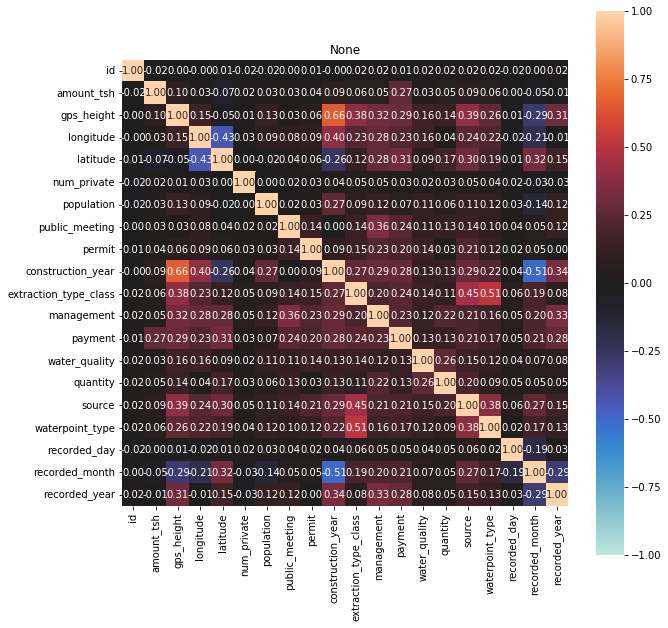

In [26]:
complete_correlation = associations(test_set_values, filename= 'complete_correlation.png', figsize=(10,10))

In [28]:
#checking correlation between categorical values that are NOT labels
categorical_features=identify_nominal_columns(test_set_values)
categorical_features

['public_meeting',
 'permit',
 'extraction_type_class',
 'management',
 'payment',
 'water_quality',
 'quantity',
 'source',
 'waterpoint_type']

In [29]:
#one-hot encode categorical variables
one_hot_df = pd.get_dummies(test_set_values, columns = categorical_features)
one_hot_df.columns

Index(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'num_private', 'population', 'construction_year', 'recorded_day',
       'recorded_month', 'recorded_year', 'public_meeting_False',
       'public_meeting_True', 'permit_False', 'permit_True',
       'extraction_type_class_gravity', 'extraction_type_class_handpump',
       'extraction_type_class_motorpump', 'extraction_type_class_other',
       'extraction_type_class_rope pump', 'extraction_type_class_submersible',
       'extraction_type_class_wind-powered', 'management_company',
       'management_other', 'management_other - school',
       'management_parastatal', 'management_private operator',
       'management_trust', 'management_unknown', 'management_vwc',
       'management_water authority', 'management_water board',
       'management_wua', 'management_wug', 'payment_never pay',
       'payment_other', 'payment_pay annually', 'payment_pay monthly',
       'payment_pay per bucket', 'payment_pay when scheme

In [30]:
one_hot_df.shape

(14850, 71)

In [31]:
test_set_values_clean = one_hot_df
test_set_values_clean.head()

,id,amount_tsh,gps_height,longitude,latitude,num_private,population,construction_year,recorded_day,recorded_month,...,source_shallow well,source_spring,source_unknown,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
0,50785,0.0,1996,35.290799,-4.059696,0,321,2012,4,2,...,0,0,0,0,0,0,0,0,0,1
1,51630,0.0,1569,36.656709,-3.309214,0,300,2000,4,2,...,0,1,0,0,1,0,0,0,0,0
2,17168,0.0,1567,34.767863,-5.004344,0,500,2010,1,2,...,0,0,0,0,0,0,0,0,0,1
3,45559,0.0,267,38.058046,-9.418672,0,250,1987,22,1,...,1,0,0,0,0,0,0,0,0,1
4,49871,500.0,1260,35.006123,-10.950412,0,60,2000,27,3,...,0,1,0,0,1,0,0,0,0,0


# Save clean test set

In [32]:
test_set_values_clean.to_csv('test_set_values_clean.csv', index=False)